In [5]:
# Data
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import impl.layer as l

# Dataset preparation and pre-processing
mnist = input_data.read_data_sets('data/MNIST_data/', one_hot=False)

X_train, y_train = mnist.train.images, mnist.train.labels
X_val, y_val = mnist.validation.images, mnist.validation.labels
X_test, y_test = mnist.test.images, mnist.test.labels
y_test.shape, y_val.shape, y_train.shape

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


((10000,), (5000,), (55000,))

In [6]:
# Pre-processing
def prepro(X_train, X_val, X_test):
    mean = np.mean(X_train)
    # scale = 255. - mean # std or sqrt(var), 255 == 2**8 or 8 bit grayscale
    # return (X_train - mean)/ scale, (X_val - mean)/ scale, (X_test - mean) / scale
    return X_train - mean, X_val - mean, X_test - mean

def selu_forward(X):
    alpha = 1.6732632423543772848170429916717
    scale = 1.0507009873554804934193349852946
    out = scale * np.where(X>=0.0, X, alpha * (np.exp(X)-1))
    cache = X
    return out, cache

def selu_backward(dout, cache):
    alpha = 1.6732632423543772848170429916717
    scale = 1.0507009873554804934193349852946
    X = cache
    dX_pos = dout.copy()
    dX_pos[X<0] = 0
    dX_neg = dout.copy()
    dX_neg[X>0] = 0
    dX = scale * np.where(X>=0.0, dX_pos, dX_neg * alpha * np.exp(X))
    return dX

# p_dropout = keep_prob
def selu_dropout_forward(h, q):
    '''h is activation, q is keep probability: q=1-p, p=p_dropout, and q=keep_prob'''
    alpha = 1.6732632423543772848170429916717
    scale = 1.0507009873554804934193349852946
    alpha_p = -scale * alpha
    mask = np.random.binomial(1, q, size=h.shape)
    dropped = (mask * h) + ((1 - mask) * alpha_p)
    a = 1. / np.sqrt(q + (alpha_p ** 2 * q  * (1 - q)))
    b = -a * (1 - q) * alpha_p
    out = (a * dropped) + b
    cache = (a, mask)
    return out, cache

def selu_dropout_backward(dout, cache):
    a, mask = cache
    d_dropped = dout * a
    dh = d_dropped * mask
    return dh

X_train, X_val, X_test = prepro(X_train, X_val, X_test)

In [7]:
# Model
import impl.layer as l # or from impl.layer import *
from impl.loss import * # import all functions from impl.loss file # import impl.loss as loss_func
from sklearn.utils import shuffle as skshuffle

class FFNN:

    def __init__(self, D, C, H, L):
        # self.mode = 'classification'
        self.L = L # number of layers or depth
        self.losses = {'train':[], 'smooth train':[], 'valid':[], 'valid_acc':[]}
        
        # The adaptive/learnable/updatable random feedforward
        self.model = []
        self.W_fixed = []
        
        # Input layer
        # m = dict(W=np.random.randn(D, H) / np.sqrt(D / 2.),
        #          b=np.zeros((1, H)))
        low, high = (-1. / np.sqrt(D / 2.)), (+1. / np.sqrt(D / 2.))
        m = dict(W=np.random.uniform(size=(D, H), low=low, high=high),
                 b=np.zeros((1, H)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(D, H), low=low, high=high)
        self.W_fixed.append(m)

        # Hidden layers
        # m = dict(W=np.random.randn(H, H) / np.sqrt(H / 2.),
        #          b=np.zeros((1, H)))
        low, high = (-1. / np.sqrt(H / 2.)), (+1. / np.sqrt(H / 2.))
        m = dict(W=np.random.uniform(size=(H, H), low=low, high=high),
                 b=np.zeros((1, H)))
        m_L = []
        for _ in range(L):
            m_L.append(m)
        self.model.append(m_L)
        # Fixed feedback weight
        m = np.random.uniform(size=(H, H), low=low, high=high)
        m_L = []
        for _ in range(L):
            m_L.append(m)
        self.W_fixed.append(m_L)
        
        # Output layer
        # m = dict(W=np.random.randn(H, C) / np.sqrt(H / 2.),
        #          b=np.zeros((1, C)))
        low, high = (-1. / np.sqrt(H / 2.)), (+1. / np.sqrt(H / 2.))
        m = dict(W=np.random.uniform(size=(H, C), low=low, high=high),
                 b=np.zeros((1, C)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(H, C), low=low, high=high)
        self.W_fixed.append(m)
        
    def fc_forward(self, X, W, b):
        out = (X @ W) + b
        cache = (W, X)
        return out, cache

    def fc_backward(self, dout, cache, W_fixed):
        W, X = cache

        dW = X.T @ dout
        db = np.sum(dout, axis=0).reshape(1, -1) # db_1xn
        # dX = dout @ W.T # Backprop
        dX = dout @ W_fixed.T # fb alignment

        return dX, dW, db

    def train_forward(self, X):
        caches = []
        
        # Input layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[0]['W'], b=self.model[0]['b']) # X_1xD, y_1xc
        y, nl_cache = selu_forward(X=y)
        X = y.copy() # pass the previous output to the next layer
        caches.append((fc_cache, nl_cache)) # caches[0]
        
        # Hidden layers
        fc_caches, nl_caches = [], []
        for layer in range(self.L):
            y, fc_cache = self.fc_forward(X=X, W=self.model[1][layer]['W'], b=self.model[1][layer]['b'])
            y, nl_cache = selu_forward(X=y)
            X = y.copy() # pass to next layer
            fc_caches.append(fc_cache)
            nl_caches.append(nl_cache)
        caches.append((fc_caches, nl_caches)) # caches[1]
        
        # Output layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[2]['W'], b=self.model[2]['b'])
        caches.append(fc_cache) # caches[2]

        return y, caches

    def loss_function(self, y, y_train):
        
        loss = cross_entropy(y, y_train) # softmax is included
        dy = dcross_entropy(y, y_train) # dsoftmax is included
        
        return loss, dy
    
    def train_backward(self, dy, caches):
        grads = []

        # Input layer
        grads.append({key: np.zeros_like(val) for key, val in self.model[0].items()})
        
        # Hidden layer
        grad = []
        for layer in range(self.L):
            grad.append({key: np.zeros_like(val) for key, val in self.model[1][layer].items()})
        grads.append(grad)

        # Outout layer
        grads.append({key: np.zeros_like(val) for key, val in self.model[2].items()})

        # Output layer
        fc_cache = caches[2]
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[2])
        dy = dX.copy() # pass it to the previous layer
        grads[2]['W'] = dW
        grads[2]['b'] = db

        # Hidden layer
        fc_caches, nl_caches = caches[1]
        for layer in reversed(range(self.L)):
            dy = selu_backward(dout=dy, cache=nl_caches[layer])
            dX, dW, db = self.fc_backward(dout=dy, cache=fc_caches[layer], W_fixed=self.W_fixed[1][layer])
            dy = dX.copy()
            grads[1][layer]['W'] = dW
            grads[1][layer]['b'] = db
        
        # Input layer
        fc_cache, nl_cache = caches[0]
        dy = selu_backward(dout=dy, cache=nl_cache)
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[0])
        grads[0]['W'] = dW
        grads[0]['b'] = db

        return dX, grads
    
    def test(self, X):
        y_logit, _ = self.train_forward(X)
        
        # if self.mode == 'classification':
        y_prob = l.softmax(y_logit) # for accuracy== acc
        y_pred = np.argmax(y_prob, axis=1) # for loss==err
        
        return y_pred, y_logit
        
    def get_minibatch(self, X, y, minibatch_size, shuffle):
        minibatches = []

        if shuffle:
            X, y = skshuffle(X, y)

        for i in range(0, X.shape[0], minibatch_size):
            X_mini = X[i:i + minibatch_size]
            y_mini = y[i:i + minibatch_size]
            minibatches.append((X_mini, y_mini))

        return minibatches

    def adam(self, train_set, val_set, alpha, mb_size, n_iter, print_after):
        X_train, y_train = train_set
        X_val, y_val = val_set

        # Momentums
        M, R = [], []

        # Input layer momentums
        M.append({key: np.zeros_like(val) for key, val in self.model[0].items()})
        R.append({key: np.zeros_like(val) for key, val in self.model[0].items()})

        # Hidden layers momentum
        M_, R_ = [], []
        for layer in range(self.L):
            M_.append({key: np.zeros_like(val) for key, val in self.model[1][layer].items()})
            R_.append({key: np.zeros_like(val) for key, val in self.model[1][layer].items()})
        M.append(M_)
        R.append(R_)

        # Output layer momentums
        M.append({key: np.zeros_like(val) for key, val in self.model[2].items()})
        R.append({key: np.zeros_like(val) for key, val in self.model[2].items()})
 
        # Learning decay
        beta1 = .9
        beta2 = .99
        smooth_train = 1.

        # Epochs
        for iter in range(1, n_iter + 1):

            # Minibatches
            #         """
            #         Single training step over minibatch: forward, loss, backprop
            #         """
            # Shuffle for each epochs/ stochasticity/ randomly choosing
            #             for idx in range(len(minibatches)):
            #             for _ in range(10):
            # Shuffle in every iteration
            # The dataset is static and non-sequentiol: no time-dependency or temporal pattern
            minibatches = self.get_minibatch(X_train, y_train, mb_size, shuffle=True)
            idx = np.random.randint(0, len(minibatches))
            X_mini, y_mini = minibatches[idx]
            
            # Train the model
            y, caches = self.train_forward(X_mini)
            loss, dy = self.loss_function(y, y_mini)
            _, grads = self.train_backward(dy, caches)
            self.losses['train'].append(loss)
            smooth_train = (0.999 * smooth_train) + (0.001 * loss)
            self.losses['smooth train'].append(smooth_train)
            
            # Update the model for input layer
            for key in grads[0].keys():
                self.model[0][key] -= alpha * grads[0][key]
                # M[0][key] = l.exp_running_avg(M[0][key], grads[0][key], beta1)
                # R[0][key] = l.exp_running_avg(R[0][key], grads[0][key]**2, beta2)
                # m_k_hat = M[0][key] / (1. - (beta1**(iter)))
                # r_k_hat = R[0][key] / (1. - (beta2**(iter)))
                # self.model[0][key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + l.eps)

            # Update the model for the hidden layers
            for layer in range(self.L):
                for key in grads[1][layer].keys():
                    self.model[1][layer][key] -= alpha * grads[1][layer][key]
                    # M[1][layer][key] = l.exp_running_avg(M[1][layer][key], grads[1][layer][key], beta1)
                    # R[1][layer][key] = l.exp_running_avg(R[1][layer][key], grads[1][layer][key]**2, beta2)
                    # m_k_hat = M[1][layer][key] / (1. - (beta1**(iter)))
                    # r_k_hat = R[1][layer][key] / (1. - (beta2**(iter)))
                    # self.model[1][layer][key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + l.eps)


            # Update the model for output layer
            for key in grads[2].keys():
                self.model[2][key] -= alpha * grads[2][key]
                # M[2][key] = l.exp_running_avg(M[2][key], grads[2][key], beta1)
                # R[2][key] = l.exp_running_avg(R[2][key], grads[2][key]**2, beta2)
                # m_k_hat = M[2][key] / (1. - (beta1**(iter)))
                # r_k_hat = R[2][key] / (1. - (beta2**(iter)))
                # self.model[2][key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + l.eps)

            # Validate the updated model
            y_pred, y_logit = self.test(X_val)
            valid_loss, _ = self.loss_function(y_logit, y_val) # softmax is included in entropy loss function
            self.losses['valid'].append(valid_loss)
            valid_acc = np.mean(y_pred == y_val)
            self.losses['valid_acc'].append(valid_acc)
            
            # Print the model info: loss & accuracy or err & acc
            if iter % print_after == 0:
                print('Iter-{} train loss: {:.4f} valid loss: {:.4f}, valid accuracy: {:.4f}'.format(
                    iter, loss, valid_loss, valid_acc))

        # Test the final model
        y_pred, y_logit = nn.test(X_test)
        loss, _ = self.loss_function(y_logit, y_test) # softmax is included in entropy loss function
        acc = np.mean(y_pred == y_test)
        print('Last iteration - Test accuracy mean: {:.4f}, std: {:.4f}, loss: {:.4f}'.format(
            acc.mean(), acc.std(), loss))

In [8]:
# Hyper-parameters
n_iter = 1000 # number of epochs
alpha = 1e-3 # learning_rate
mb_size = 64 # 2**10==1024 # width, timestep for sequential data or minibatch size
print_after = 10 # n_iter//10 # print loss for train, valid, and test
num_hidden_units = 32 # number of kernels/ filters in each layer
num_input_units = X_train.shape[1] # noise added at the input lavel as input noise we can use dX or for more improvement
num_output_units = y_train.max() + 1 # number of classes in this classification problem
num_layers = 1 # depth 

# Build the model/NN and learn it: running session.
nn = FFNN(C=num_output_units, D=num_input_units, H=num_hidden_units, L=num_layers)

nn.adam(train_set=(X_train, y_train), val_set=(X_val, y_val), mb_size=mb_size, alpha=alpha, 
           n_iter=n_iter, print_after=print_after)

Iter-10 train loss: 2.2661 valid loss: 2.2793, valid accuracy: 0.1468
Iter-20 train loss: 2.2665 valid loss: 2.2780, valid accuracy: 0.1498
Iter-30 train loss: 2.2958 valid loss: 2.2768, valid accuracy: 0.1522
Iter-40 train loss: 2.3168 valid loss: 2.2760, valid accuracy: 0.1536
Iter-50 train loss: 2.2450 valid loss: 2.2747, valid accuracy: 0.1552
Iter-60 train loss: 2.2292 valid loss: 2.2734, valid accuracy: 0.1578
Iter-70 train loss: 2.2691 valid loss: 2.2725, valid accuracy: 0.1598
Iter-80 train loss: 2.3287 valid loss: 2.2715, valid accuracy: 0.1608
Iter-90 train loss: 2.2568 valid loss: 2.2707, valid accuracy: 0.1634
Iter-100 train loss: 2.2408 valid loss: 2.2696, valid accuracy: 0.1654
Iter-110 train loss: 2.3067 valid loss: 2.2687, valid accuracy: 0.1672
Iter-120 train loss: 2.2528 valid loss: 2.2676, valid accuracy: 0.1692
Iter-130 train loss: 2.3546 valid loss: 2.2665, valid accuracy: 0.1706
Iter-140 train loss: 2.2369 valid loss: 2.2654, valid accuracy: 0.1712
Iter-150 train 

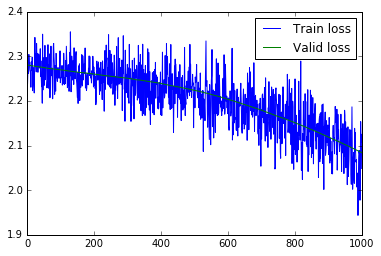

In [9]:
# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(nn.losses['train'], label='Train loss')
# plt.plot(nn.losses['smooth train'], label='Train smooth loss')
plt.plot(nn.losses['valid'], label='Valid loss')
plt.legend()
plt.show()

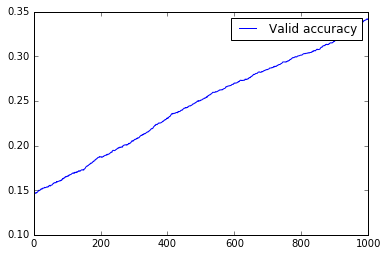

In [10]:
plt.plot(nn.losses['valid_acc'], label='Valid accuracy')
plt.legend()
plt.show()